# Guided Project: Creating a Kaggle Workflow

## 1. Introducing Data Science Workflows

In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.
In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.
To get started, we'll read in the original train.csv and test.csv files from Kaggle.

In [1]:
# Import the pandas library
import pandas as pd
import numpy as np

In [2]:
# Use pandas to import the file train.csv as train.
train=pd.read_csv('train.csv')
train.shape

(891, 12)

In [3]:
# Use pandas to import the file test.csv as holdout.
holdout=pd.read_csv('test.csv')
holdout.shape

(418, 11)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
# Display the first few lines of the test dataframe.
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2. Preprocessing the Data


In [7]:
#Use the %load magic command to load the contents of functions.py into a notebook cell and read through the functions you have imported.


In [8]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [9]:
# Create a new function to preprocess the Data
def preprocess_data(df,dummy_list):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_cabin(df)
    process_titles(df)
    
    for i in dummy_list:
        df=create_dummies(df,i)
    return df

In [10]:
# Apply the newly create function on the train and holdout dataframes.
dummy_list=["Age_categories", "Fare_categories","Title", "Cabin_type","Sex"]
train=preprocess_data(train,dummy_list)
holdout=preprocess_data(holdout,dummy_list)

In [11]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,0,0,1,1,0


## 3. Exploring the Data

Review the data dictionary and variable notes for the Titanic competition on Kaggle's website to familiarize yourself with the SibSp and Parch columns.

<li>SibSp - The number of siblings or spouses the passenger had aboard the Titanic
<li>Parch - The number of parents or children the passenger had aboard the Titanic

In [12]:
# Use pandas and matplotlib to explore those two columns.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
train[['SibSp','Parch','Survived']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


In [13]:
# Explore SibSp
print(train['SibSp'].value_counts())


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


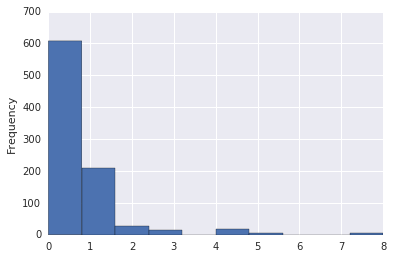

In [14]:
train['SibSp'].plot.hist()

In [15]:
print(train['SibSp'].value_counts(normalize=True)*100)

0    68.237935
1    23.456790
2     3.142536
4     2.020202
3     1.795735
8     0.785634
5     0.561167
Name: SibSp, dtype: float64


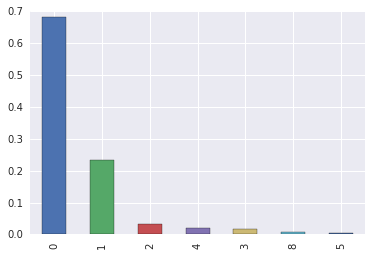

In [16]:
train['SibSp'].value_counts(normalize=True).plot.bar()

In [17]:
train.pivot_table(index='SibSp',values='Survived')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


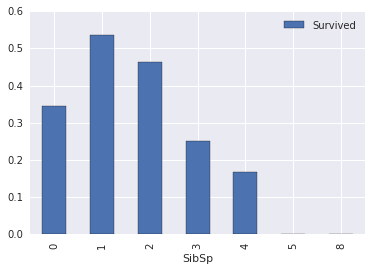

In [18]:
train.pivot_table(index='SibSp',values='Survived').plot.bar()

In [19]:
train[train['SibSp']==5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,...,0,0,0,0,0,0,0,1,0,1
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,...,0,0,0,0,0,0,0,1,1,0
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,...,0,0,0,0,0,0,0,1,0,1
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,...,0,0,0,0,0,0,0,1,0,1
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,...,0,0,0,0,0,0,0,1,0,1


#Write a markdown cell explaining your SibSp findings.
<li>68% of the passengers (group A) were travelling without having siblings or spouses. The survivalrate of this group is almost 35%.
<li>32% of the passengers (group B) were travelling with siblings or spouses, with a maximum of 8. The survivalrate of passengers having 1 or 2 siblings or spouses are the highest, the rate is even higher than passengers A. However, passengers with 5 or more siblings or spouses have a survivalrate of zero.

In [20]:
# Explore Parch
print(train['Parch'].value_counts())

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


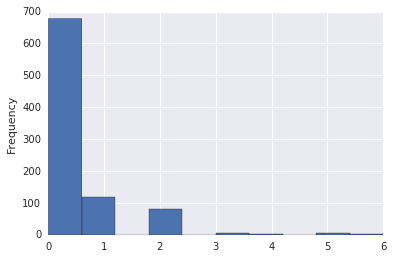

In [21]:
train['Parch'].plot.hist()

In [22]:
print(train['Parch'].value_counts(normalize=True)*100)

0    76.094276
1    13.243547
2     8.978676
5     0.561167
3     0.561167
4     0.448934
6     0.112233
Name: Parch, dtype: float64


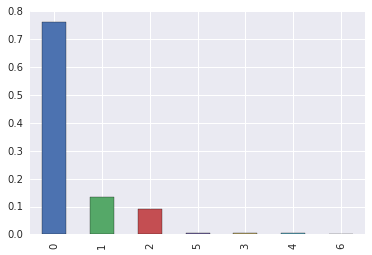

In [23]:
train['Parch'].value_counts(normalize=True).plot.bar()

In [24]:
train.pivot_table(index='Parch',values='Survived')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


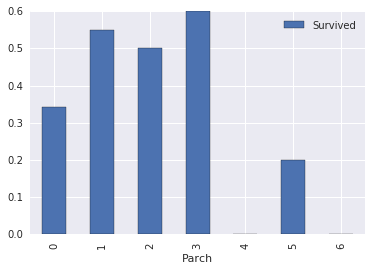

In [25]:
train.pivot_table(index='Parch',values='Survived').plot.bar()

#Write a markdown cell explaining your Parch findings.
<li>76% of the passengers were travelling without parents or children (group C). This group has a survivalrate of 34%.
<li>24% of the passengers were travelling with parents or children (group D), with a max of 6. The passengers with 1,2 or 3 parents or children have the highest survivalrate, even higher than group C. However, passengers travelling with 4 or 6 parents or children have a survivalrate of zero.


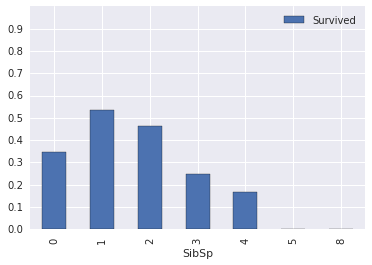

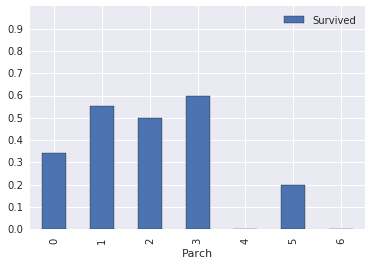

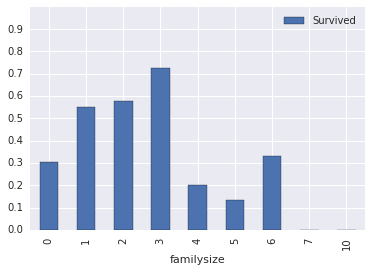

In [26]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

## 4. Engineering New Features

In [27]:
# Create a function, that indicates whether the passenger was alone or not:
def isalone(df):
    df['familysize']=df[["SibSp","Parch"]].sum(axis=1)
    df['isalone']=0
    df.loc[(df['familysize']==0),'isalone']=1
    return df

In [28]:
# Apply the newly created function to the train and holdout dataframes.
train=isalone(train)
holdout=isalone(holdout)

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,familysize,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,1,0,1


In [30]:
print(train.select_dtypes(include=['integer','float']).columns)
print(train.select_dtypes([np.number]).columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'familysize', 'isalone'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
      

## 5. Selecting the Best-Performing Features

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    #Removes any non-numeric columns
    numeric_columns=df.select_dtypes([np.number])
    #Removes any columns containing null values
    df=numeric_columns.dropna(axis=1)
    print(len(df.columns))
    print(df.columns)
    #Creates all_X and all_y variables
    all_X=df.drop(['PassengerId','Survived'],axis=1)
    all_y=df['Survived']
    #Perform recursive feature elimination and the random forests algorithm to find the best-performing set of features
    rfc=RandomForestClassifier(random_state=1)
    selector=RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns=list(all_X.columns[selector.support_])
    print(len(optimized_columns))
    print(optimized_columns)
    return optimized_columns

In [32]:
#Run the newly created function using the train dataframe as input and assign the result to a variable.
best_performing_features=select_features(train)

37
Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'familysize', 'isalone'],
      dtype='object')
34
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
  
  
difference between selected features and available features are PassengerID, Survived and Cabin_type_T...

## 6. Selecting and Tuning Different Algorithms

In [33]:
#Import model_selection.GridSearchCV, neighbors import KNeighborsClassifier, and linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Create a function, select_model()
def select_model(df,features):

    #Split the dataframe
    all_X=df[features]
    all_y=df['Survived']
    
    #Create a list of dictionaries
    models=[
        {
            'name':'LogisticRegression',
             'estimator':LogisticRegression(),
             'hyperparameters':
                 {
                     "solver": ["newton-cg", "lbfgs", "liblinear"]
                 }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator':KNeighborsClassifier(),
            'hyperparameters':
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            'name':'RandomForestClassifier',
            'estimator':RandomForestClassifier(random_state=1),
            'hyperparameters':
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        }
    ]
    
    #Iterate over that list of dictionaries
    for i in models:
        print(i['name'])
        print('-'*len(i['name']))
        grid=GridSearchCV(i['estimator'],param_grid=i['hyperparameters'],cv=10)
        grid.fit(all_X,all_y)
        i['best_performing_parameters']=grid.best_params_
        i['best_performing_score']=grid.best_score_
        i['best_model']=grid.best_estimator_
        print('best_performing_parameters: {}'.format(i['best_performing_parameters']))
        print('best_performing_score: {}\n'.format(i['best_performing_score']))
    
    #Return the list of dictionaries
    return models



In [34]:
#Run the newly created function using the train dataframe and the output of select_features() as inputs and assign the result to a variable.
dictionary_model_performances=select_model(train,best_performing_features)

LogisticRegression
------------------
best_performing_parameters: {'solver': 'newton-cg'}
best_performing_score: 0.8181818181818182

KNeighborsClassifier
--------------------
best_performing_parameters: {'p': 1, 'n_neighbors': 3, 'algorithm': 'kd_tree', 'weights': 'uniform'}
best_performing_score: 0.7800224466891134

RandomForestClassifier
----------------------
best_performing_parameters: {'min_samples_split': 5, 'max_depth': 10, 'criterion': 'entropy', 'n_estimators': 9, 'max_features': 'log2', 'min_samples_leaf': 1}
best_performing_score: 0.8406285072951739



In [35]:
dictionary_model_performances

[{'best_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
            verbose=0, warm_start=False),
  'best_performing_parameters': {'solver': 'newton-cg'},
  'best_performing_score': 0.8181818181818182,
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'name': 'LogisticRegression'},
 {'best_model': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=1,
             weights='uniform'),
  'best_performing_parameters'

## 7. Making a Submission to Kaggle

In [42]:
#Create a function, save_submission_file()
def save_submission_file(best_model,features,filename):
    all_X=holdout[features]
    holdout_predictions=best_model.predict(all_X)
    submission_df={'PassengerId':holdout['PassengerId'],'Survived':holdout_predictions}
    submission=pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)
    

In [43]:
best_model=dictionary_model_performances[2]['best_model']
save_submission_file(best_model,best_performing_features,'submission.csv')